
## Image classification on a Fashion clothes dataset

![](https://cdn-images-1.medium.com/max/2000/1*K_Dloai-KV-4ZIMLW4YfjQ.jpeg)

Compared to TensorFlow, PyTorch offers several advantages as a Deep Learning library. For one, it is much easier to use in Python because of it executes code at runtime. This is different from TensorFlow, in which we define the execution graph first, with the input and output shapes, activation functions, and order of each layer. The code is then run in a separate session. In PyTorch, you define the graph as a class of type nn.module, and feed the input data through it. The code runs as the class is called. This has several advantages as well, because the code is easier to read and intuitive, and because of its runtime-execution model, it is easy to debug the code as the data passes through the model.

## The Data

For this project, I am going to be using the Fashion MNIST dataset. The Fashion MNIST dataset consists of Zalando’s article images, with grayscale images of size 28x28, developed as a drop-in replacement for the MNIST handwritten digits dataset. For most machine learning models, the handwritten digits dataset is very easy to train on, yielding almost 100% accuracy with simple convolutional neural networks. Although it provides a good metric to validate models, it is not very challenging. The Fashion MNIST dataset provides this challenge, with more complicated features to train on.

## The Model

To train images, we use a convolutional neural network (CNN). CNNs are a type of deep layer neural networks, used to learn Filters that when convolved with the image, can be used to extract features.

In this network, there are 5 convolution layers. In the first layer, there are 6 filters being learnt. We step the filters across the input to update the values. These kernel values are propagated forward to calculate the loss, and re-updated through backpropagation. We have different numbers of convolution filters for each layer, or different sizes, and with different activation functions. For this project, the model we will use will have the following architecture

![Neural Network architecture](https://cdn-images-1.medium.com/max/4304/1*YvoWTDr0w8S8KWKyLFfOCg.png)

We will have 2 convolution layers, with 5x5 kernels, followed by a fully connected layer, and a final activation for the last output layer. Now, let’s look into the code and follow through an example of implementing a Convolutional Neural Network in Pytorch.

## Imports

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt


Apart from the general Python imports for math, random, Pandas, and and Numpy, we will import the Torch utilities. These include the torch, torch.nn, and torch.utils for the Dataset loaders.

Let’s declare the essential hyperparameters:

In [0]:
num_epochs = 25
batch_size = 100
learning_rate = 0.001

## Data Loading

In Pytorch, for data loading, we use a ready function to download and load data

In [0]:
train_dataset = dsets.FashionMNIST(root='./data',
                                   train=True,
                                   transform=transforms.ToTensor(),
                                   download=True)

test_dataset = dsets.FashionMNIST(root='./data',
                                  train=False,
                                  transform=transforms.ToTensor(),
                                  download=True)

And using these, define the data loaders using the DataLoader module

In [0]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

Now, by iterating over the loader, we can get the items in batch to process on.

We can also use the data reader to visualize some images and see the dataset:

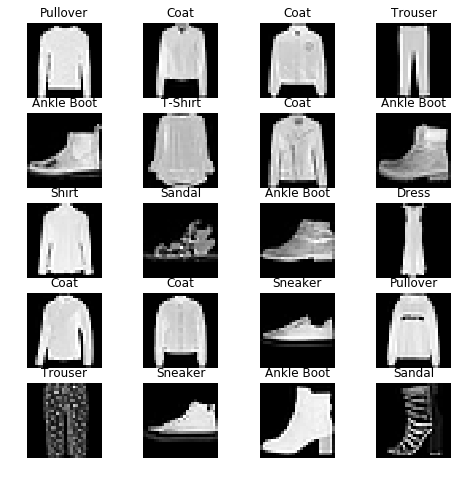

In [14]:
labels_map = {0: 'T-Shirt', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt',
              7: 'Sneaker', 8: 'Bag', 9: 'Ankle Boot'}
fig = plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows + 1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0, :, :]
    fig.add_subplot(rows, columns, i)
    plt.title(labels_map[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img, cmap='gray')
plt.show()


## The Network

The next main part of the project is to implement the Neural Network graph. This is one of the things I really like about PyTorch over TensorFlow and Keras, as PyTorch makes defining graphs much more easier and intuitive to understand.

Neural Networks are inherited from the nn.Module class, and define the graph in the constructor. We will implement two functions, the __init__ and **forward**. Let’s look through the code:

In [0]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7 * 7 * 32, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

It looks fairly simple. In the constructor, we define the layers using the provided modules from the nn package. A sequence of a layer, normalization, activation and pooling can be defined as a Sequential. For instance, a convolution layer is defined as nn.Conv2d(in_channels, out_channels, kernel_size, padding, stride) . After the two convolution layers and activations, we end the network with a Fully Connected layer that outputs to 10 classes.

The forward function is called on the Neural Network for a set of inputs, and it passes that input through the different layers that have been defined. In this case, we pass x through the first layer, pass it’s output through the second layer, and pass that through the final fully connected layer to get the output. The view function in the code about reshapes the output to match the dimensions required for the final layer.

## Training the model

After defining the Neural Network graph, we need to declare the loss function to optimize, and start training the model. Let’s do that next

In [16]:
# instance of the Conv Net
cnn = CNN()
# Enable GPU
use_cuda = True
if use_cuda and torch.cuda.is_available():
    cnn.cuda()
# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
print(cnn)

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


Next, let’s train it:

In [17]:
losses = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = Variable(images.float())
        labels = Variable(labels)

        # Forward + Backward + Optimize
        optimizer.zero_grad()
        outputs = cnn(images.cuda())
        loss = criterion(outputs, labels.cuda())
        loss.backward()
        optimizer.step()

        losses.append(loss.data)

        if (i + 1) % 100 == 0:
            print('Epoch : %d/%d, Iter : %d/%d,  Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_dataset) // batch_size, loss.data))

Epoch : 1/25, Iter : 100/600,  Loss: 0.4177
Epoch : 1/25, Iter : 200/600,  Loss: 0.3076
Epoch : 1/25, Iter : 300/600,  Loss: 0.3219
Epoch : 1/25, Iter : 400/600,  Loss: 0.3520
Epoch : 1/25, Iter : 500/600,  Loss: 0.2536
Epoch : 1/25, Iter : 600/600,  Loss: 0.3121
Epoch : 2/25, Iter : 100/600,  Loss: 0.2887
Epoch : 2/25, Iter : 200/600,  Loss: 0.2504
Epoch : 2/25, Iter : 300/600,  Loss: 0.3345
Epoch : 2/25, Iter : 400/600,  Loss: 0.3105
Epoch : 2/25, Iter : 500/600,  Loss: 0.2716
Epoch : 2/25, Iter : 600/600,  Loss: 0.4154
Epoch : 3/25, Iter : 100/600,  Loss: 0.2373
Epoch : 3/25, Iter : 200/600,  Loss: 0.3191
Epoch : 3/25, Iter : 300/600,  Loss: 0.1659
Epoch : 3/25, Iter : 400/600,  Loss: 0.3430
Epoch : 3/25, Iter : 500/600,  Loss: 0.2135
Epoch : 3/25, Iter : 600/600,  Loss: 0.2170
Epoch : 4/25, Iter : 100/600,  Loss: 0.2337
Epoch : 4/25, Iter : 200/600,  Loss: 0.1773
Epoch : 4/25, Iter : 300/600,  Loss: 0.2017
Epoch : 4/25, Iter : 400/600,  Loss: 0.2985
Epoch : 4/25, Iter : 500/600,  L

Here, we iterate over a batch of images in the train_loader. For each batch, we do the following steps:

* Zero out the gradients in the optimizer. Because the backward() function accumulates gradients, we don’t want to mix values between mini batches.

* Feed the data through the convolution net. This calls the forward() function and gets its output.

* Calculate the loss based on the outputs and actual labels.

* Backpropagate the gradients.

* Update the parameters based on the back propagated values.

I am also adding the loss values to an array, and printing out progress messages periodically.

Running it on my machine, here are some of the epoch results I achieved:

The final loss was less than **0.1**, which is really good for only 25 epochs.

## Evaluating the model

Having trained the model, let’s evaluate it on our test dataset. The code:

In [18]:
cnn.eval()
correct = 0
total = 0
for images, labels in test_loader:
    images = Variable(images.float())
    outputs = cnn(images.cuda())
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels.cuda()).sum()
print('Test Accuracy of the model on the 10000 test images: %.4f %%' % (100 * correct / total))

Test Accuracy of the model on the 10000 test images: 90.0000 %


What we are doing here:

* Change the mode of the network to eval

* Feed the images through the network to get the outputs

* Get the output label by taking the max from the one-hot outputs

* Count the correct predictions by comparing them to the labels

My evaluation returned an accuracy of **90.7300 %**.

## **Visualizing the loss**

I decided to visualize the loss from the training over the number of epochs

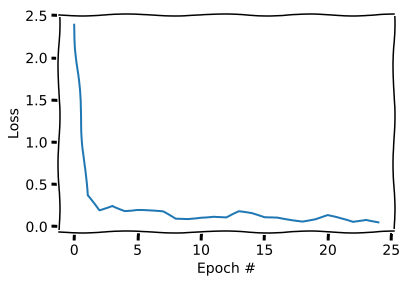

In [22]:
losses_in_epochs = losses[0::600]
plt.xkcd()
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.plot(losses_in_epochs)
# plt.plot(losses)
plt.show()

## Visualizing the Filters

We can also visualize the filters. In a convolutional network, we are letting the network learn the filters that help it classify an image. For instance, the network could identify edges by learning a filter that acts as a edge detector. A more complicated one could learn to identify the handles on a bag. Let’s visualize the filters from the first layer and the second layer:

<Figure size 432x288 with 0 Axes>

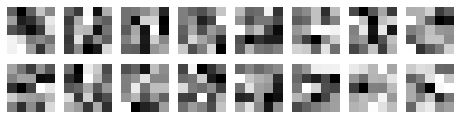

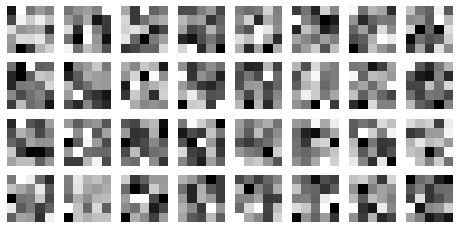

In [24]:
def plot_kernels(tensor, num_cols=6):
    num_kernels = tensor.shape[0]
    num_rows = 1 + num_kernels // num_cols
    fig = plt.figure(figsize=(num_cols, num_rows))
    for i in range(num_kernels):
        ax1 = fig.add_subplot(num_rows,num_cols, i + 1)
        ax1.imshow(tensor[i][0, :, :], cmap='gray')
        ax1.axis('off')
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()
model_layers = [i for i in cnn.children()]
first_layer = model_layers[0]
second_layer = model_layers[1]
first_kernels = first_layer[0].weight.data.cpu().numpy()
plot_kernels(first_kernels, 8)
second_kernels = second_layer[0].weight.data.cpu().numpy()
plot_kernels(second_kernels, 8)

It may be difficult to decipher what these filters are identifying, but their convolutions on the fashion images are able to properly classify it’s label with high accuracy.